# Análise de avaliações de hotéis

In [1]:
#rom google.colab import drive
#drive.mount('/content/drive')

#import os
#workdir_path = '/content/drive/My Drive' #MODIFICAR!!! #Caminho para o seu workspace
#os.chdir(workdir_path)

### 1. Observação inicial dos dados

In [2]:
#!pip install liac-arff
import arff
import pandas as pd

dataset = arff.load(open('hoteis.arff', 'r', encoding="ISO-8859-1"))
data = pd.DataFrame(dataset['data'])
data.columns = ['text', 'class']

# Estrutura dos dados

data.head()

,text,class
0,vocês são o melhor,pos
1,foi muito grato trabalhar com voces,pos
2,realizei o aniversario de meu sobrinho na terc...,pos
3,gostei muito do atendimento personalizado/n,pos
4,"grande hotel com otimas acomodacoes, a beira d...",pos


In [3]:
# Quantidade de linhas

print(data.shape[0])

411


In [4]:
# Existem valores nulos (por coluna)?

print(data.isnull().any())

text     False
class    False
dtype: bool


In [5]:
# Quantidade de avaliações positivas e negativas

data['class'].value_counts()

pos    207
neg    204
Name: class, dtype: int64

### 2. Separação dos dados

In [6]:
from sklearn.model_selection import train_test_split

# Separação do label e das features
X = data.drop('class', axis=1).values
y = data['class'].values

# Separação de dados de treino e teste
train_features, test_features, class_train, class_test = train_test_split(X, y, test_size=0.20, random_state=10)

### 3. StopWords

In [7]:

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/LeonardoLins/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 4. CountVectorizer

In [8]:
from sklearn.feature_extraction.text import CountVectorizer #bag of words

# Criação de matriz com a contagem de cada token SEM stop words
cv = CountVectorizer(max_features=10000)
cv_train_features = cv.fit_transform(train_features.ravel())
cv_test_features = cv.transform(test_features.ravel())

print('Shape das features de treino:', cv_train_features.shape, ' Shape das features de teste:', cv_test_features.shape)

# Criação de matriz com a contagem de cada token COM stop words
cv_sw = CountVectorizer(stop_words = stopwords.words('portuguese'),max_features=10000)
cv_sw_train_features = cv_sw.fit_transform(train_features.ravel())
cv_sw_test_features = cv_sw.transform(test_features.ravel())


print('Shape das features de treino:', cv_sw_train_features.shape, ' Shape das features de teste:', cv_sw_test_features.shape)

Shape das features de treino: (328, 2340)  Shape das features de teste: (83, 2340)
Shape das features de treino: (328, 2227)  Shape das features de teste: (83, 2227)


### 5. Funções Auxiliares

In [9]:
from sklearn import metrics

def train_predict_model(classifier, 
                        train_features, train_labels, 
                        test_features, test_labels):
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features) 
    return predictions 

In [12]:
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]): #É possivel retirar os [0,1].

    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)

    cm_frame = pd.DataFrame(cm, index=classes, columns=classes,)
    cm_frame.index.name = 'Actual'
    cm_frame.columns.name = 'Predicted'

    print(cm_frame)

def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)

def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)
    
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))


### 6. Random Forest

#### 6.1 RF com stop words

In [13]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rfc = RandomForestClassifier(n_jobs=-1)

rfc_tfidf_predictions = train_predict_model(classifier=rfc, 
                                                train_features=cv_sw_train_features, train_labels=class_train,
                                                test_features=cv_sw_test_features, test_labels=class_test)

display_model_performance_metrics(true_labels=class_test
                                  ,predicted_labels=rfc_tfidf_predictions
                                  ,classes=['pos', 'neg']
                                 )

Model Performance metrics:
------------------------------
Accuracy: 0.8313
Precision: 0.8611
Recall: 0.8313
F1 Score: 0.8274

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.76      0.98      0.85        42
         neg       0.97      0.68      0.80        41

    accuracy                           0.83        83
   macro avg       0.86      0.83      0.83        83
weighted avg       0.86      0.83      0.83        83


Prediction Confusion Matrix:
------------------------------
Predicted  pos  neg
Actual             
pos         41    1
neg         13   28


#### 6.2 RF sem stop words

In [14]:
rfc_tfidf_predictions = train_predict_model(classifier=rfc, 
                                                train_features=cv_train_features, train_labels=class_train,
                                                test_features=cv_test_features, test_labels=class_test)

display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_tfidf_predictions,classes=['pos', 'neg'])

Model Performance metrics:
------------------------------
Accuracy: 0.8313
Precision: 0.8438
Recall: 0.8313
F1 Score: 0.8295

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.78      0.93      0.85        42
         neg       0.91      0.73      0.81        41

    accuracy                           0.83        83
   macro avg       0.84      0.83      0.83        83
weighted avg       0.84      0.83      0.83        83


Prediction Confusion Matrix:
------------------------------
Predicted  pos  neg
Actual             
pos         39    3
neg         11   30


### 7. TF-IDF

O valor tf–idf, é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico. Ela é frequentemente utilizada como fator de ponderação na recuperação de informações e na mineração de dados.

O valor tf–idf de uma palavra aumenta proporcionalmente à medida que aumenta o número de ocorrências dela em um documento, no entanto, esse valor é equilibrado pela frequência da palavra no corpus. Isso auxilia a distinguir o fato da ocorrência de algumas palavras serem geralmente mais comuns que outras.

In [16]:
from sklearn.feature_extraction.text import  TfidfVectorizer

tv = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(train_features.ravel())
tv_test_features = tv.transform(test_features.ravel())

print('Shape das features de treino:', tv_train_features.shape, ' Shape das features de teste:', tv_test_features.shape, '\n')

rfc_tfidf_predictions = train_predict_model(classifier=rfc, 
                                               train_features=tv_train_features, train_labels=class_train,
                                               test_features=tv_test_features, test_labels=class_test)
display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_tfidf_predictions,classes=['pos', 'neg'])

Shape das features de treino: (328, 9678)  Shape das features de teste: (83, 9678) 

Model Performance metrics:
------------------------------
Accuracy: 0.8193
Precision: 0.8346
Recall: 0.8193
F1 Score: 0.8169

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.76      0.93      0.84        42
         neg       0.91      0.71      0.79        41

    accuracy                           0.82        83
   macro avg       0.84      0.82      0.82        83
weighted avg       0.83      0.82      0.82        83


Prediction Confusion Matrix:
------------------------------
Predicted  pos  neg
Actual             
pos         39    3
neg         12   29


### 8. STEMMER

In [17]:
nltk.download('rslp')
stemmer = nltk.stem.RSLPStemmer()

X = data.drop('class', axis=1).values
y = data['class'].values

corpus = []
for review in data['text']:
    phrase = []
    for word in review.split():
        w_stemmed = stemmer.stem(word)
        phrase.append(w_stemmed)
    corpus.append(phrase)
# Separate data into train and test
train_features, test_features, class_train, class_test = train_test_split(corpus, y, test_size=0.20, random_state=10)

rfc_stem_predictions = train_predict_model(classifier=rfc, 
                                               train_features=tv_train_features, train_labels=class_train,
                                               test_features=tv_test_features, test_labels=class_test)
display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_stem_predictions,classes=['pos', 'neg'])

[nltk_data] Downloading package rslp to
[nltk_data]     /Users/LeonardoLins/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


Model Performance metrics:
------------------------------
Accuracy: 0.8072
Precision: 0.8347
Recall: 0.8072
F1 Score: 0.8028

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         pos       0.74      0.95      0.83        42
         neg       0.93      0.66      0.77        41

    accuracy                           0.81        83
   macro avg       0.84      0.81      0.80        83
weighted avg       0.83      0.81      0.80        83


Prediction Confusion Matrix:
------------------------------
Predicted  pos  neg
Actual             
pos         40    2
neg         14   27


### 9. Separação de palavras positivas e negativas

In [18]:
# Palavras negativas, removendo stopwords

neg_phrases = data[data['class'] == 'neg']
neg_string = []
for phrase in neg_phrases['text']:
    for word in phrase.split():
        if word not in stopwords.words('portuguese'):
            neg_string.append(word)

neg_text = pd.Series(neg_string).str.cat(sep=' ')

In [19]:
# Palavras positivas, removendo stopwords

pos_phrases = data[data['class'] == 'pos']
pos_string = []
for phrase in pos_phrases['text']:
    for word in phrase.split():
        if word not in stopwords.words('portuguese'):
            pos_string.append(word)

pos_text = pd.Series(pos_string).str.cat(sep=' ')

### 10. WordCloud

Word cloud de palavras negativas

In [ ]:
#!pip install wordcloud

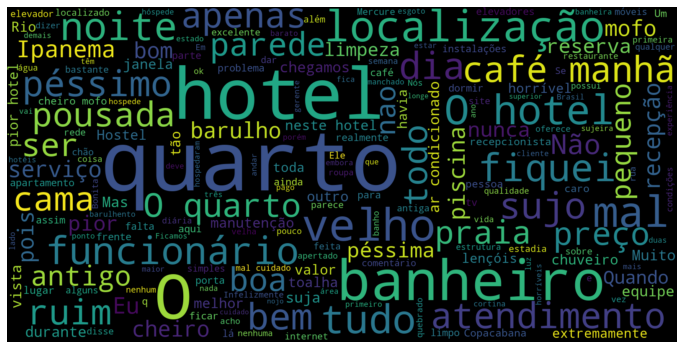

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud de palavras positivas

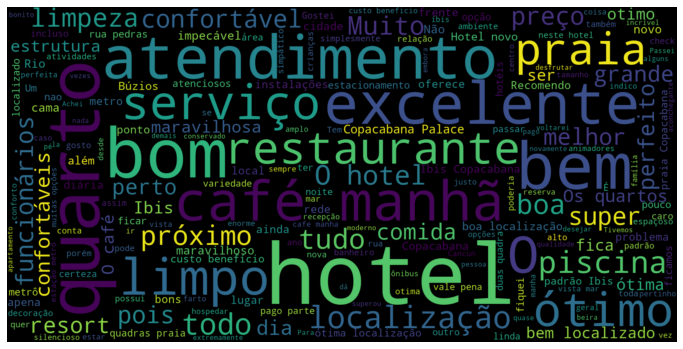

In [21]:

wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()